In [16]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [17]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [18]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [19]:
# sub number
sub_num = 5

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 5s 47ms/step - loss: 0.6477 - accuracy: 0.7060 - val_loss: 0.6075 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.7544
Epoch 00002: val_loss improved from inf to 0.57800, saving model to best_model_6.h5
99/99 [==============================] - 4s 45ms/step - loss: 0.5778 - accuracy: 0.7544 - val_loss: 0.5780 - val_accuracy: 0.7367
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7544
Epoch 00003: val_loss improved from 0.57800 to 0.56882, saving model to best_model_6.h5
99/99 [==============================] - 4s 45ms/step - loss: 0.5574 - accuracy: 0.7544 - val_loss: 0.5688 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.56882 to 0.55314, saving model to best_model_6.h5
99/99 [==============================] - 4s 45ms/step

99/99 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9173
Epoch 00029: val_loss improved from 0.15467 to 0.15405, saving model to best_model_6.h5
99/99 [==============================] - 4s 41ms/step - loss: 0.1661 - accuracy: 0.9173 - val_loss: 0.1540 - val_accuracy: 0.9297
Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9243
Epoch 00030: val_loss did not improve from 0.15405
99/99 [==============================] - 4s 41ms/step - loss: 0.1672 - accuracy: 0.9243 - val_loss: 0.1860 - val_accuracy: 0.9173
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9246
Epoch 00031: val_loss did not improve from 0.15405
99/99 [==============================] - 4s 41ms/step - loss: 0.1652 - accuracy: 0.9246 - val_loss: 0.1601 - val_accuracy: 0.9297
Epoch 32/200
99/99 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9068
Epoch 00032: val_loss did not improve from 0.1540

Epoch 58/200
99/99 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9306
Epoch 00058: val_loss improved from 0.13569 to 0.12813, saving model to best_model_6.h5
99/99 [==============================] - 4s 42ms/step - loss: 0.1399 - accuracy: 0.9306 - val_loss: 0.1281 - val_accuracy: 0.9430
Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9458
Epoch 00059: val_loss improved from 0.12813 to 0.12459, saving model to best_model_6.h5
99/99 [==============================] - 4s 42ms/step - loss: 0.1226 - accuracy: 0.9458 - val_loss: 0.1246 - val_accuracy: 0.9487
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9341
Epoch 00060: val_loss did not improve from 0.12459
99/99 [==============================] - 4s 41ms/step - loss: 0.1356 - accuracy: 0.9341 - val_loss: 0.1491 - val_accuracy: 0.9335
Epoch 61/200
99/99 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9411

Epoch 87/200
99/99 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9617
Epoch 00087: val_loss did not improve from 0.10192
99/99 [==============================] - 4s 39ms/step - loss: 0.0950 - accuracy: 0.9617 - val_loss: 0.1162 - val_accuracy: 0.9563
Epoch 88/200
99/99 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9617
Epoch 00088: val_loss improved from 0.10192 to 0.09999, saving model to best_model_6.h5
99/99 [==============================] - 4s 39ms/step - loss: 0.0913 - accuracy: 0.9617 - val_loss: 0.1000 - val_accuracy: 0.9601
Epoch 89/200
99/99 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9534
Epoch 00089: val_loss did not improve from 0.09999
99/99 [==============================] - 4s 39ms/step - loss: 0.1066 - accuracy: 0.9534 - val_loss: 0.1927 - val_accuracy: 0.9249
Epoch 90/200
99/99 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9569
Epoch 00090: val_loss did not improv

Epoch 116/200
99/99 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9642
Epoch 00116: val_loss did not improve from 0.08830
99/99 [==============================] - 4s 39ms/step - loss: 0.0818 - accuracy: 0.9642 - val_loss: 0.1031 - val_accuracy: 0.9620
Epoch 117/200
99/99 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9674
Epoch 00117: val_loss did not improve from 0.08830
99/99 [==============================] - 4s 39ms/step - loss: 0.0812 - accuracy: 0.9674 - val_loss: 0.0970 - val_accuracy: 0.9591
Epoch 118/200
99/99 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9712
Epoch 00118: val_loss did not improve from 0.08830
99/99 [==============================] - 4s 39ms/step - loss: 0.0627 - accuracy: 0.9712 - val_loss: 0.1401 - val_accuracy: 0.9420
Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9712
Epoch 00119: val_loss did not improve from 0.08830
99/99 [===========

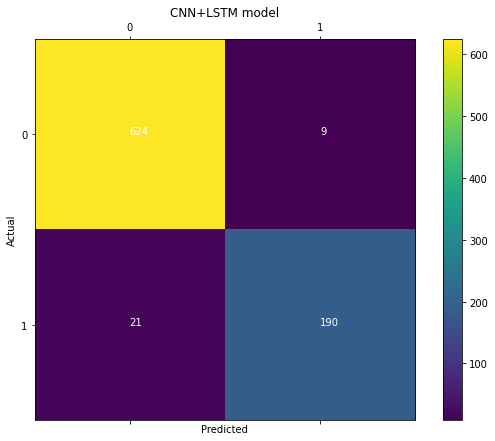

val_loss: 0.08829853683710098
test_loss: 0.09679172188043594
test_acc: 0.9644549489021301
precision: 0.9547738693467337
recall: 0.9004739336492891
specificity 0.985781990521327
sensitivity :  0.9004739336492891
far 0.014218009478672985
frr 0.0995260663507109


In [20]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 48, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 27, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.16519178106690297)(max_2)
    
    
lstm_1 = tf.keras.layers.LSTM(159)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(8, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(241, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(13, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_3)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00025897385811766787), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0016556065892678969, momentum=0.9102646030327244), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)